<a href="https://www.kaggle.com/code/nishantpatel54/30day-stock-forecast-lstm?scriptVersionId=146169495" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 32.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.16.3-cp310-cp310-linux_x86_64.whl size=314460 sha256=c8e5ae6a6d394d5adbfa0a1211b407cf3265f77ad025b953d5b1cf1f11759c07
  Stored in directory: /root/.cache/pip/wheels/c8/ac/6d/ad6d828725ffbe3abc508c95d25dd0c5fcc63539ae47913790
Successfully built peewee


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

ticker = 'AAPL'
lookback = 60
forecast = 30
end_train='2022-08-02'
start_val='2022-08-03'
#account for 3 years of trading days.
trading_day = 252
days_in_year = 365
period = 3
history = int((365*period)+((365-252)*period))

start_train = datetime.datetime.strptime(end_train, '%Y-%m-%d').date() - datetime.timedelta(days = history)
start_train = start_train.strftime("%Y-%m-%d")

dataset = yf.download(ticker, start=start_train, end=end_train)

dataset_val = yf.download(ticker, start_val)

train_set = dataset[['Close']].fillna(method='ffill')
train_set = train_set.values.reshape(-1,1)

val_set = dataset_val[['Close']].fillna(method='ffill').head(lookback+forecast)
val_set = val_set.values.reshape(-1,1)

train_set.shape, val_set.shape, start_train

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


((987, 1), (90, 1), '2018-08-29')

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
sc = sc.fit(train_set)
train_set_scaled = sc.transform(train_set)

sc_val = MinMaxScaler(feature_range=(0,1))
sc_val = sc_val.fit(val_set)
val_set_scaled = sc_val.transform(val_set)
val_set_scaled[:10], train_set_scaled[:10]

(array([[0.78780251],
        [0.77973781],
        [0.76814528],
        [0.75604824],
        [0.75730839],
        [0.86617952],
        [0.84727832],
        [0.93825614],
        [0.9657258 ],
        [0.96169345]]),
 array([[0.13790219],
        [0.14140138],
        [0.14583939],
        [0.14708543],
        [0.14454211],
        [0.13810704],
        [0.13503457],
        [0.12996501],
        [0.13938723],
        [0.13464199]]))

In [4]:
X_train=[]
y_train=[]
X_val=[]
y_val=[]

for i in range(lookback, len(train_set_scaled) - forecast + 1):
    X_train.append(train_set_scaled[i - lookback : i])
    y_train.append(train_set_scaled[i : i + forecast])

for i in range(lookback, len(val_set_scaled) - forecast + 1):
    X_val.append(val_set_scaled[i - lookback : i])
    y_val.append(val_set_scaled[i : i + forecast])
    
X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val = np.array(y_val)


In [5]:
#model

model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=100,return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(forecast))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 60, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 100)           64400     
                                                                 
 dropout_1 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

1. Adding Dropout layers to avoid overfitting and get a flat forecast compared to not using dropouts. 
2. Inner dropout is higher than input layer to avoid any adverse effects.

* We are adjusting the number of nodes based on the dropout rate, proposed number of nodes/dropout rate. hidden = 50/0.5 = 100

In [6]:
#train

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/100
29/29 [==============================] - 11s 196ms/step - loss: 0.1024 - val_loss: 0.0188
Epoch 2/100
29/29 [==============================] - 5s 158ms/step - loss: 0.0366 - val_loss: 0.0151
Epoch 3/100
29/29 [==============================] - 5s 161ms/step - loss: 0.0282 - val_loss: 0.0150
Epoch 4/100
29/29 [==============================] - 5s 156ms/step - loss: 0.0214 - val_loss: 0.0155
Epoch 5/100
29/29 [==============================] - 5s 157ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 6/100
29/29 [==============================] - 5s 160ms/step - loss: 0.0174 - val_loss: 0.0152
Epoch 7/100
29/29 [==============================] - 5s 165ms/step - loss: 0.0158 - val_loss: 0.0161
Epoch 8/100
29/29 [==============================] - 5s 167ms/step - loss: 0.0150 - val_loss: 0.0179
Epoch 9/100
29/29 [==============================] - 5s 161ms/step - loss: 0.0138 - val_loss: 0.0194
Epoch 10/100
29/29 [==============================] - 5s 164ms/step - loss: 0.0132 - val_l

1/1 [==============================] - 1s 1s/step


/tmp/ipykernel_21/1525350728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


(          Date      Actual    Forecast
 0   2018-08-29   55.744999         NaN
 1   2018-08-30   56.257500         NaN
 2   2018-08-31   56.907501         NaN
 3   2018-09-04   57.090000         NaN
 4   2018-09-05   56.717499         NaN
 ..         ...         ...         ...
 982 2022-07-26  151.600006         NaN
 983 2022-07-27  156.789993         NaN
 984 2022-07-28  157.350006         NaN
 985 2022-07-29  162.509995         NaN
 986 2022-08-01  161.509995  161.509995
 
 [987 rows x 3 columns],
                  Close    Forecast
 Date                              
 2022-08-01  161.509995  161.509995
 2022-08-03  166.130005  157.668579
 2022-08-04  165.809998  157.290756
 2022-08-05  165.350006  157.548630
 2022-08-08  164.869995  158.792282
 2022-08-09  164.919998  158.163818
 2022-08-10  169.240005  157.433914
 2022-08-11  168.490005  157.629501
 2022-08-12  172.100006  157.971146
 2022-08-15  173.190002  157.842926
 2022-08-16  173.029999  156.993164
 2022-08-17  174.550003  

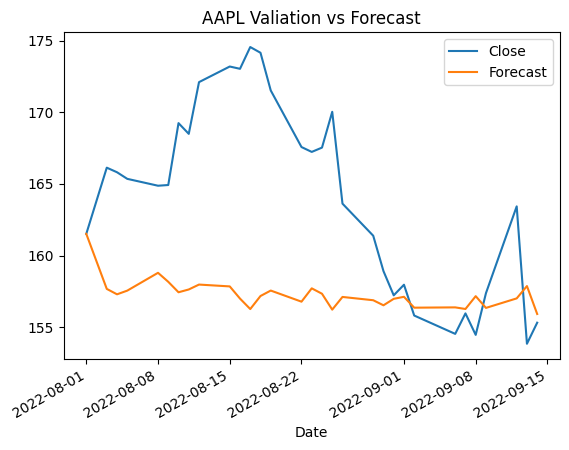

In [7]:
X_ = train_set_scaled[-lookback:]
X_ = X_.reshape(1, lookback, 1)

y_ = model.predict(X_).reshape(-1,1)
y_ = sc.inverse_transform(y_)

dataset_past = dataset[['Close']].reset_index()
dataset_past.rename(columns={'index':'Date','Close':'Actual'},inplace=True)
dataset_past['Date'] = pd.to_datetime(dataset_past['Date'])
dataset_past['Forecast'] = np.nan
dataset_past['Forecast'].iloc[-1] = dataset_past['Actual'].iloc[-1]


dataset_future = dataset_val[['Close']].reset_index()
dataset_future = dataset_future.head(forecast)
dataset_future.rename(columns={'index':'Date','Close':'Validation'})
dataset_future['Date'] = pd.to_datetime(dataset_future['Date'])
dataset_future['Forecast'] = y_.flatten()
dataset_future.set_index('Date', inplace=True)

data=[]
insert_first = {'Date':dataset_past['Date'].iloc[-1], 'Close':dataset_past['Actual'].iloc[-1], 'Forecast':dataset_past['Actual'].iloc[-1]}
data.insert(0,insert_first)
data=pd.DataFrame(data)
data.set_index('Date', inplace=True)
dataset_future = pd.concat([data, dataset_future])


dataset_future.plot(title=ticker + " Valiation vs Forecast")
dataset_past, dataset_future

* With an increased dropout rate on the inner layers it does a better job of forecasting the general trend of the stock over the next 30 training days. 
* Main problem with such a linear forecast is we can't really have a best time to buy and sell the stock over the next 30 days, just take a fixed position either long or short at the start of the trend till the end. For example on August 01, 2022 you would short the stock as we forecast it to drop by Sept 15,2022.